In part 3 we'll use the fact that emissions have yearly pattern. 

Let's load the datasets and compare years (straight lines represent the absence of covid data):

In [77]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_full_original = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'emission', 'year', 'week_no', 'latitude', 'longitude'])
test_original = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                        usecols=['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no', 'latitude', 'longitude'])

test_weeks = 49


four_representatives = pd.read_csv('new_datasets/four_representatives.csv', index_col=0)
four_representatives.columns = ["Location"]
four_representatives["Group"] = ['Special 1', 'Special 2', 'High', 'Low']


# Create date feature
train_full_original['date'] = pd.to_datetime(train_full_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(train_full_original.week_no.mul(7).astype(str) + ' days')
test_original['date'] = pd.to_datetime(test_original.year.astype(str), format='%Y') + \
                     pd.to_timedelta(test_original.week_no.mul(7).astype(str) + ' days')

# Create Location feature
train_full_original["Location"] = train_full_original['latitude'].astype('string') + \
       train_full_original['longitude'].astype('string')
test_original["Location"] = test_original['latitude'].astype('string') + test_original['longitude'].astype('string')

# Pre-covid data
train_precovid_original = train_full_original[train_full_original['date'] < pd.to_datetime('2020-03-18')].copy(deep=True)
precovid_weeks = 53 + len(train_precovid_original[train_precovid_original['year'] == 2020]['week_no'].unique())

# Post-covid data
train_postcovid_original = train_full_original[train_full_original['date'] >  pd.to_datetime('2020-08-26')].copy(deep=True)

# No-covid data
train_nocovid_original = pd.concat([train_precovid_original, train_postcovid_original])

CPU times: total: 750 ms
Wall time: 831 ms


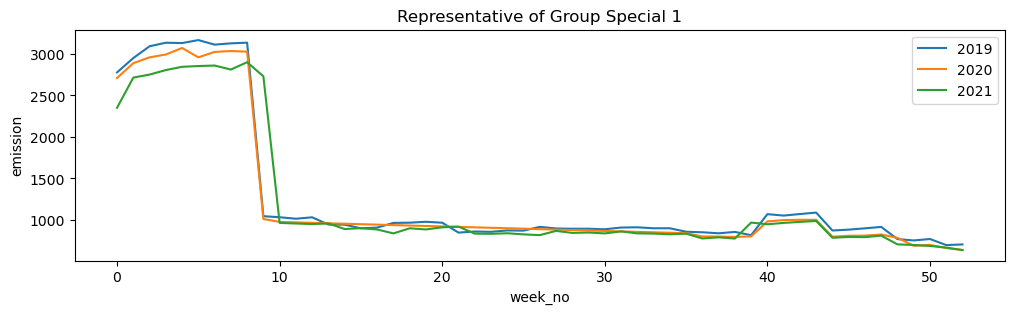

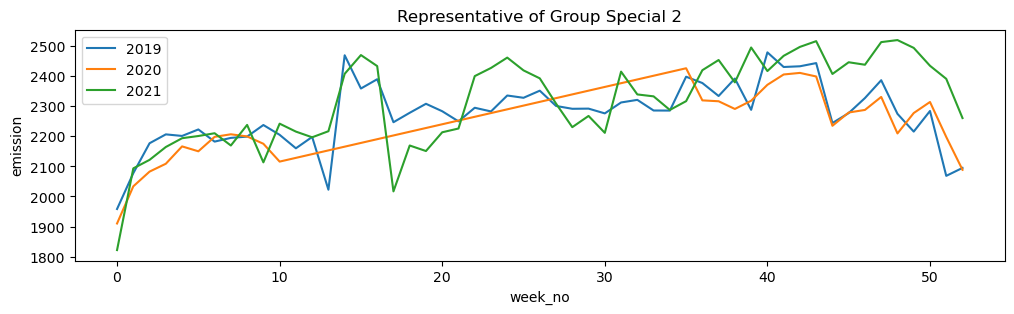

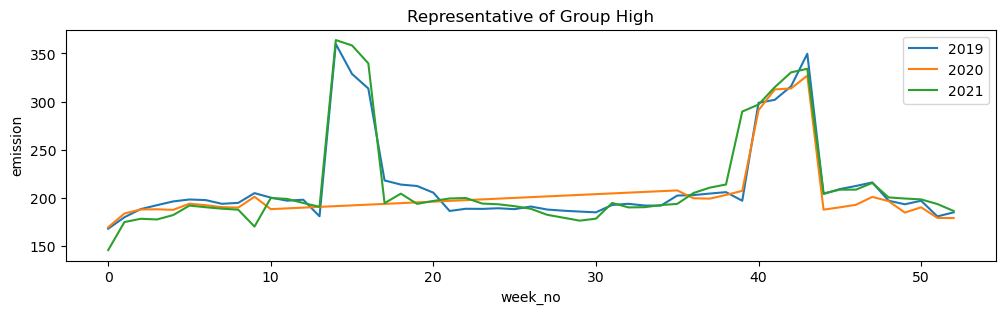

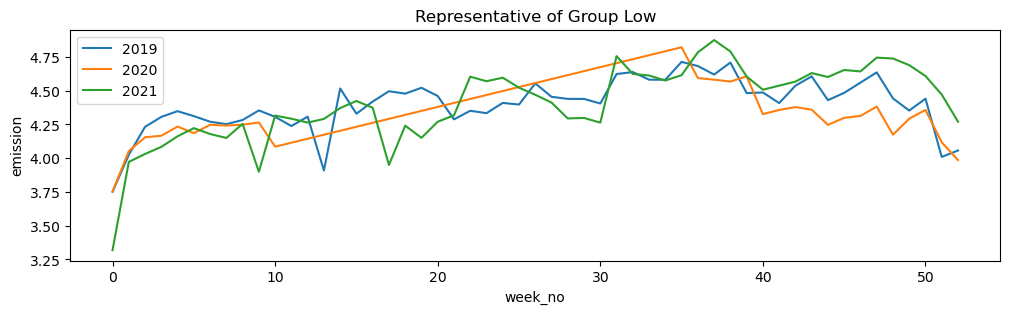

CPU times: total: 688 ms
Wall time: 818 ms


In [78]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns


for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    for year in [2019, 2020, 2021]:
        sns.lineplot(data = train_nocovid_original[(train_nocovid_original["Location"] == representative['Location']) &
                                 (train_nocovid_original['year'] == year)], x='week_no', y='emission', label=year).\
                set(title='Representative of Group {}'.format(representative["Group"]))
    plt.show()

We'll create a dataset with the same target and new features. 

The training (and time-series cross-validation) test will contain data from 2020 (no 'covid period', though) and 2021.

Our first feature will represent the amount of emissions one year ago at the same location (NaN if one year ago was covid period).

## 00. The "One year ago" feature

In [79]:
%%time

study_number = '00'

## Create a pivot table with emissions by year, week_no and location
emissions_by_week = pd.pivot_table(train_nocovid_original, index=['year', 'week_no'], columns='Location', values='emission')


# NaNs for COVID data
for w in range(11, 35):
    emissions_by_week.loc[(2020, w), :] = np.nan



## Create the new feature
for i in train_nocovid_original[train_nocovid_original['year'] > 2019].index:
    train_nocovid_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(train_nocovid_original.loc[i, 'year'] - 1,
                                                                        train_nocovid_original.loc[i, 'week_no']),
                                                                        train_nocovid_original.loc[i, 'Location']]
for i in test_original.index:
    test_original.loc[i, 'OneYearAgo'] = emissions_by_week.loc[(test_original.loc[i, 'year'] - 1,
                                                                        test_original.loc[i, 'week_no']),
                                                                        test_original.loc[i, 'Location']]
    
test_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   latitude    24353 non-null  float64       
 1   longitude   24353 non-null  float64       
 2   year        24353 non-null  int64         
 3   week_no     24353 non-null  int64         
 4   date        24353 non-null  datetime64[ns]
 5   Location    24353 non-null  string        
 6   OneYearAgo  24353 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), string(1)
memory usage: 2.0+ MB
CPU times: total: 15.9 s
Wall time: 18.5 s


In [80]:
%%time

# Create train and test DataFrames

train = train_nocovid_original.loc[train_nocovid_original['year'] > 2019, ['OneYearAgo', 'emission']].copy(deep=True)
test = pd.DataFrame(test_original['OneYearAgo'])

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 40754 entries, ID_-0.510_29.290_2020_00 to ID_-3.299_30.301_2021_52
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OneYearAgo  28826 non-null  float64
 1   emission    40754 non-null  float64
dtypes: float64(2)
memory usage: 955.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OneYearAgo  24353 non-null  float64
dtypes: float64(1)
memory usage: 896.6+ KB
None
CPU times: total: 0 ns
Wall time: 13.3 ms


Let's look at a scatterplot of 'emission' vs. 'OneYearAgo':

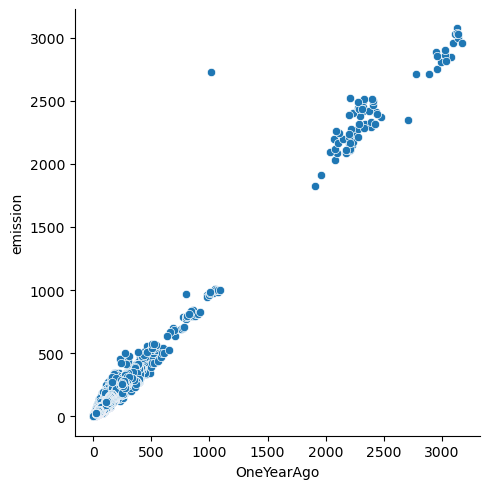

CPU times: total: 188 ms
Wall time: 285 ms


In [81]:
%%time

sns.relplot(data=train, x='OneYearAgo', y='emission')
plt.show()

Let's test:

In [82]:
%%time

scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})


# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb

# Instantiate the estimator
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1)

# Calculate scores
from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train,
                                                                   test,
                                                                   model, scores_df,
                                                        comment="OneYearAgo lgb")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 8.59 s
Wall time: 941 ms


In [84]:
scores_df.loc[int(study_number), 'Test RMSE'] = 56.82272
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,OneYearAgo,66.856795,86.119355,56.82272


In [ ]:
## 01. Year

Next, let's add 'year'